<a href="https://colab.research.google.com/github/Sravani-05/DLAssignment_3/blob/main/NN_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Write a colab in JAX only from scratch 3 layer deep neural network for non linear regression using low-level and high-level API**

In [1]:
# Imports

import jax
from jax import numpy as jnp
from jax import grad, value_and_grad
from jax.example_libraries import stax, optimizers

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Generate non-linear data

n = 1000
dim = 3
x = np.random.uniform(-1, 1, (n, dim))
print('Input shape =', x.shape)

Input shape = (1000, 3)


In [3]:
# Initialize weights and bias

weights = np.array([[2, -3, 1]]).T
bias = np.array([8])
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = np.einsum('ij, jk -> ik', (x**3),  weights) + np.einsum('ij, jk -> ik', (x**2),  weights) + np.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (1000, 1)


In [4]:
# Hyperparamter initializations

input_dim = dim
output_dim = 1
hidden_dim = 16

learning_rate = 0.01
num_epochs = 50

seed = jax.random.PRNGKey(101)

**Using low-level API**

In [5]:
def initialize_weights(input_dim, output_dim, hidden_dim, seed):
  weights = []

  # Weights for 1st hidden layer
  w = jax.random.uniform(key=seed, shape=(input_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for 2nd hidden layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for output layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, output_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(output_dim,), dtype=jnp.float32)
  weights.append([w,b])

  return weights

In [6]:
# Non-linear activation function

def relu(x):
  return jnp.maximum(x, jnp.zeros_like(x))

In [7]:
# Linear layer

def linear(weights, input, activation=lambda x: x):
  weights, bias = weights
  out = jnp.dot(input, weights) + bias
  return activation(out)

In [8]:
# Forward pass

def forward(weights, input):
  layer_out = input

  for i in range(len(weights[:-1])):
    layer_out = linear(weights[i], layer_out, relu)

  preds = linear(weights[-1], layer_out)

  return preds.squeeze()

In [9]:
# Error function - Mean Square Error

def mean_squared_error(weights, input, actual):
    preds = forward(weights, input)
    return jnp.power(actual - preds, 2).mean()

In [10]:
# Computing gradients using JAX grad

def backward(weights, input, actual):
    loss = grad(mean_squared_error)
    gradients = loss(weights, input, actual)
    return gradients

In [11]:
# Train network

def train(weights, x, y_true, learning_rate, num_epochs):
  loss_ =  []

  for epoch in range(num_epochs):
    loss_value = mean_squared_error(weights, x, y_true)
    gradients = backward(weights, x, y_true)

    # Update Weights
    for j in range(len(weights)):
      weights[j][0] -= learning_rate * gradients[j][0] 
      weights[j][1] -= learning_rate * gradients[j][1]

    print(f'Epoch {epoch}, loss {loss_value}')
    loss_.append(loss_value)

  return loss_

In [12]:

# Initialize weights
weights = initialize_weights(input_dim, output_dim, hidden_dim, seed)

# Train model
loss_ = train(weights, x, y_true, learning_rate, num_epochs)

Epoch 0, loss 16.01488494873047
Epoch 1, loss 15.358464241027832
Epoch 2, loss 15.054459571838379
Epoch 3, loss 14.810151100158691
Epoch 4, loss 14.604357719421387
Epoch 5, loss 14.428594589233398
Epoch 6, loss 14.27801513671875
Epoch 7, loss 14.147966384887695
Epoch 8, loss 14.034889221191406
Epoch 9, loss 13.936592102050781
Epoch 10, loss 13.851147651672363
Epoch 11, loss 13.776599884033203
Epoch 12, loss 13.711186408996582
Epoch 13, loss 13.653763771057129
Epoch 14, loss 13.603259086608887
Epoch 15, loss 13.558711051940918
Epoch 16, loss 13.519091606140137
Epoch 17, loss 13.483972549438477
Epoch 18, loss 13.452691078186035
Epoch 19, loss 13.42475700378418
Epoch 20, loss 13.399765014648438
Epoch 21, loss 13.377339363098145
Epoch 22, loss 13.3571195602417
Epoch 23, loss 13.338857650756836
Epoch 24, loss 13.322324752807617
Epoch 25, loss 13.307332038879395
Epoch 26, loss 13.293701171875
Epoch 27, loss 13.28127384185791
Epoch 28, loss 13.269878387451172
Epoch 29, loss 13.259432792663574

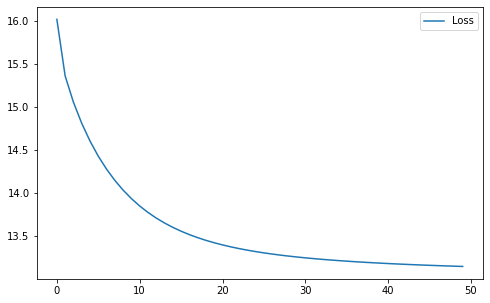

In [13]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

**Using high-level API**

In [14]:
# Create 3 layer deep neural network with non-linear activation function

init, apply = stax.serial(stax.Dense(input_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(output_dim),
                          )

In [15]:
# Loss function

def mean_squared_error(weights, input, y_true):
    y_pred = apply(weights, input).squeeze()
    return jnp.power(y_true - y_pred, 2).mean()

In [16]:
# Training neural netwrok method

def train(x, y_true, num_epochs, opt_state):
  loss_ = []

  for epoch in range(num_epochs):
    # Optimizer state is an object that has weights of our model
    loss_value, gradients = value_and_grad(mean_squared_error)(optimizer_get_weights(opt_state), x, y_true)

    # Update Weights
    opt_state = optimizer_update(epoch, gradients, opt_state)

    loss_.append(loss_value)
    print(f'Epoch {epoch}, loss {loss_value}')

  return opt_state, loss_

In [18]:
# Initialize weights by passing input dimensions to init function 

weights = init(seed, (x.shape[1],))
weights = weights[1]

optimizer_init, optimizer_update, optimizer_get_weights = optimizers.sgd(learning_rate)
optimizer_state = optimizer_init(weights)

final_optimizer_state, loss_ = train(x, y_true, num_epochs, optimizer_state)

Epoch 0, loss 75.96087646484375
Epoch 1, loss 70.9893569946289
Epoch 2, loss 65.98839569091797
Epoch 3, loss 60.5131721496582
Epoch 4, loss 54.2773551940918
Epoch 5, loss 47.08503723144531
Epoch 6, loss 38.931175231933594
Epoch 7, loss 30.187576293945312
Epoch 8, loss 22.073396682739258
Epoch 9, loss 16.4293155670166
Epoch 10, loss 14.02153205871582
Epoch 11, loss 13.496599197387695
Epoch 12, loss 13.423036575317383
Epoch 13, loss 13.397433280944824
Epoch 14, loss 13.376322746276855
Epoch 15, loss 13.356889724731445
Epoch 16, loss 13.338944435119629
Epoch 17, loss 13.32245922088623
Epoch 18, loss 13.307555198669434
Epoch 19, loss 13.293770790100098
Epoch 20, loss 13.28096866607666
Epoch 21, loss 13.269042015075684
Epoch 22, loss 13.257913589477539
Epoch 23, loss 13.247502326965332
Epoch 24, loss 13.237747192382812
Epoch 25, loss 13.228628158569336
Epoch 26, loss 13.220063209533691
Epoch 27, loss 13.21200180053711
Epoch 28, loss 13.204388618469238
Epoch 29, loss 13.197237968444824
Epoch

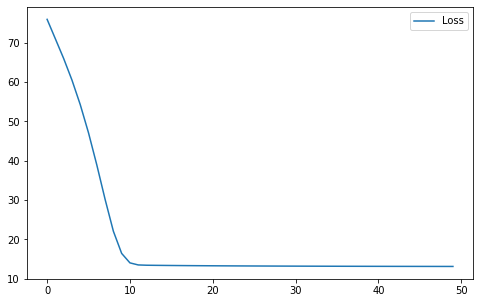

In [19]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()